In [1]:
%cd '/content/drive/MyDrive/Colab Notebooks/stepik/m4. inference/w4. tasks'
!ls

/content/drive/MyDrive/Colab Notebooks/stepik/m4. inference/w4. tasks
'4.2 bioinformatics.ipynb'  '4.4 ab testing.ipynb'
'4.3 from github.ipynb'      ab_browser_test.csv
'4.3 scoring.ipynb'	     credit_card_default_analysis.csv
'4.3 tests.ipynb'	     gene_high_throughput_sequencing.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportion_confint


Загрузим данные.

In [4]:
data = pd.read_csv('credit_card_default_analysis.csv')
n = data.shape[0]

---
# 1.Анализ влияния размера кредита на вероятность его возврата

## Подготовка данных

Разобъем данные по кредитным димитам на две подвыборки - возвращенные и дефолтные кредиты

In [5]:
limit_normal = data[data['default'] == 0]['LIMIT_BAL']
limit_default = data[data['default'] == 1]['LIMIT_BAL']

## Визуальный анализ данных

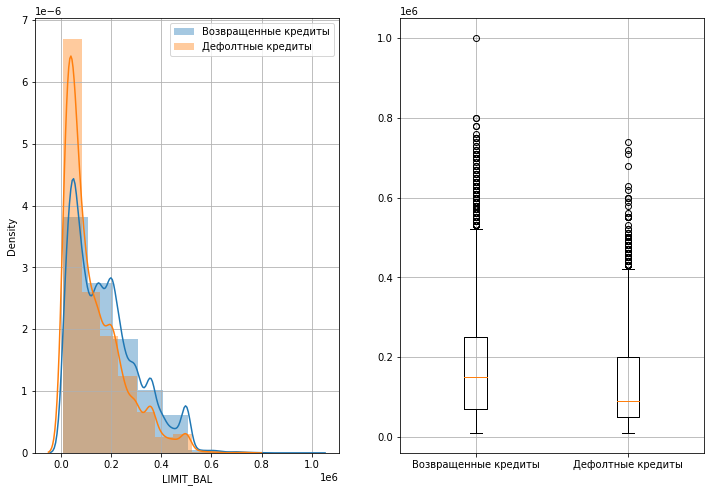

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
ax=axes[0]
limit_data = [limit_normal, limit_default]
labels = ['Возвращенные кредиты', 'Дефолтные кредиты']

for d, l in zip(limit_data, labels):
    sns.distplot(d, bins=10, ax=ax, kde=True, label=l)
ax.legend()
ax.grid()

ax = axes[1]
ax.boxplot(limit_data, vert=True, labels=labels)
ax.grid()
plt.show()

Вывод: распределения не похожи на нормальные. Распределение для возвращенных кредитов имеет большее медианное значение.

## Расчет точечных оценок

In [7]:
print('Медиана кредитного лимита в подвыборке возвращенных кредитов: ', np.quantile(limit_normal, 0.5))
print('Медиана кредитного лимита в подвыборке дефолтных кредитов: ', np.quantile(limit_default, 0.5))

Медиана кредитного лимита в подвыборке возвращенных кредитов:  150000.0
Медиана кредитного лимита в подвыборке дефолтных кредитов:  90000.0


Вывод: точечная оценка медианы кредитного лимита больше в подвыборке возвращенных кредитов

## Проверка распределение на нормальность

Выполним проверку визуально, с помощью qq-графика

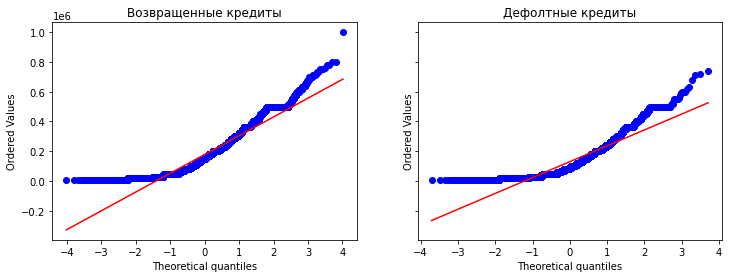

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True)
datasets = [limit_normal, limit_default]
titles = ['Возвращенные кредиты', 'Дефолтные кредиты']
for ax, dataset, title in zip(axes, datasets, titles):
    stats.probplot(dataset, dist="norm", plot=ax)
    ax.title.set_text(title)
plt.show()

Судя по графикам, распределение данных в обеих подвыборках отличается от нормального. Выполним проверку гипотезы о нормальности распределения.

$H_0$ Данные в подвыборках распределены нормально

$H_1$ Распределение данных в подвыборках не является нормальным

$\alpha = 0.05$

Критерий Шапиро-Уилка, односторонний

In [9]:
stat, pvalue = stats.shapiro(limit_normal)
print(f'Подвыборка возвращенных кредитов: W-статистика = {stat}, p-value = {pvalue}')
stat, pvalue = stats.shapiro(limit_default)
print(f'Подвыборка дефолтных кредитов: W-статистика = {stat}, p-value = {pvalue}')

Подвыборка возвращенных кредитов: W-статистика = 0.9197262525558472, p-value = 0.0
Подвыборка дефолтных кредитов: W-статистика = 0.8549829721450806, p-value = 0.0


Вывод: для обеих подвыборок p-value меньше уровня значимости, гипотезу о нормальности распределения можно отвергнуть.

---
## 1.a Построение доверительных интервалов


Построим доверительные интервалы для медианы кредитного лимита в подвыборках возвращенных и дефолтных кредитов на основе бутстрепа

Вид интервалов: двусторонние

Уровень значимости $\alpha = 0.05$

In [10]:
def get_bootstrap_samples(x, n_samples):
    return x[np.random.randint(0, len(x), (n_samples, len(x)))]

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries
                               
def get_medians(x):                            
    bootstrap_samples = get_bootstrap_samples(x.values, 1000)
    return np.median(bootstrap_samples, axis=1)

np.random.seed(42)
limit_normal_medians = get_medians(limit_normal)
limit_default_medians = get_medians(limit_default)
median_diffs = limit_normal_medians - limit_default_medians
print('95% доверительный интервал для медианы кредитного лимита:\n')
print('в подвыборке возвращенных кредитов', stat_intervals(limit_normal_medians))
print('в подвыборке дефолтных кредитов', stat_intervals(limit_default_medians))
print('\n95% доверительный интервал для разности медиан:', stat_intervals(median_diffs))


95% доверительный интервал для медианы кредитного лимита:

в подвыборке возвращенных кредитов [150000. 150000.]
в подвыборке дефолтных кредитов [80000. 90000.]

95% доверительный интервал для разности медиан: [60000. 70000.]


Вывод: 95% доверительные интервалы для медиан подвыборок не пересекаются. 95% доверительный интервал для разности медиан подвыборок не содержит 0. Это свидетельствует в пользу **статистической значимости** наблюдаемого различия в медианных значениях подвыборок.

---
## 1.b Проверка гипотезы

Поскольку распределение не является нормальным, нужно использовать непараметрические критерии. Выборки независимы, можно применить критерий Манна-Уитни.

$H_0$ Распределения кредитного лимита в подвыборках возвращеных и дефолтных кредитов равны между собой

$H_1$ Распределения подвыборок отличаются сдвигом

$\alpha = 0.05$

Критерий Манна-Уитни, двусторонний


In [11]:
ustat, pvalue = stats.mannwhitneyu(limit_normal, limit_default, alternative='two-sided')
print(f'U-статистика: {ustat}, достигаемый уровень значимости: {pvalue}')

U-статистика: 95786286.5, достигаемый уровень значимости: 1.2255485818223303e-189


Вывод: достигаемый уровень значимости меньше $alpha$, гипотеза о равенстве распределений отвергается.

Оценим практическую значимость полученного результата. В качестве количественной меры значимости будем использовать [размер эффекта](https://en.wikipedia.org/wiki/Effect_size). Выборка большая, что позволяет аппроксимировать распределение U-статистики нормальным. По достигаемому уровню значимости p-value рассчитываем z-score:

In [12]:
zscore = -stats.norm.ppf(pvalue / 2)
print(f'z-score: {zscore}')

z-score: 29.372714575049404


Используем полученный z-score для расчета размера эффекта по Коэну r, используя [формулу](https://stats.stackexchange.com/questions/124501/mann-whitney-u-test-confidence-interval-for-effect-size):

$r = \frac{z}{\sqrt{n}}$

In [13]:
r = zscore / np.sqrt(n)
print(f'Effect size: {r}')

Effect size: 0.16958344666734818


Следуя [рекомендованному эмпирическому правилу](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d), полученный размер эффекта нужно признать **практически незначимым**. Однако, с учетом специфики проблемной области, вывод может быть другим. Более точная оценка требует экспертных знаний.

Вывод: влияние размера кредита на вероятность его возврата значимо статистически, но незначимо практически

# 2.Анализ гендерного состава групп вернувших и не вернувших кредит

## Подготовка данных

Выполним сдвиг так, чтобы мужскому полу соответствовало значение 0, женскому - значение 1

In [14]:
data['SEX'] = data['SEX'] - 1
gender_normal = data[data['default'] == 0]['SEX']
gender_default= data[data['default'] == 1]['SEX']

## Визуальный анализ данных

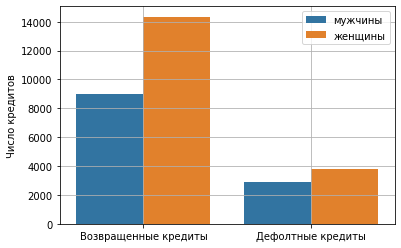

In [15]:
ax = sns.countplot(x="default", hue="SEX", data=data)
ax.set(xlabel='', ylabel='Число кредитов')
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['мужчины','женщины'], bbox_to_anchor=(1, 1))
ax.set_xticklabels(titles)
ax.grid()
plt.show()

Вывод: по графикам можно предположить, что доля мужчин больше в группе дефолтных кредитов.

## Расчет точечных оценок

Рассчитаем долю мужчин в обеих группах

In [16]:
def get_point_estimate(sample):
    return len(sample[sample == 0]) / len(sample)

p_normal = get_point_estimate(gender_normal)
p_default = get_point_estimate(gender_default)
print('Точечная оценка доли мужчин')
print('в подвыборке вернувших кредит: ', p_normal)
print('в подвыборке не вернувших кредит: ', p_default)

Точечная оценка доли мужчин
в подвыборке вернувших кредит:  0.38585002568053417
в подвыборке не вернувших кредит:  0.43294153104279687


Вывод: точечная оценка показывает, что заемщики-мужчины более склонны не возвращать кредиты

## 2.a Построение доверительных интервалов

Построим доверительные интервалы для доли мужчин в подвыборках возвращенных и дефолтных кредитов на основе бутстрепа

Вид интервалов: двусторонние

Уровень значимости $\alpha = 0.05$

In [17]:
def get_prop_confint(sample):
    male_cnt = len(sample[sample == 0])
    return proportion_confint(male_cnt, len(sample), method = 'normal')

ci_normal = get_prop_confint(gender_normal)
ci_default = get_prop_confint(gender_default)
print('95% доверительный интервал для доли мужчин')
print('в подвыборке вернувших кредит: ', ci_normal)
print('в подвыборке не вернувших кредит: ', ci_default)

95% доверительный интервал для доли мужчин
в подвыборке вернувших кредит:  (0.37960806572767264, 0.3920919856333957)
в подвыборке не вернувших кредит:  (0.4210202357094044, 0.44486282637618935)


Вывод: доверительные интервалы не пересекаются, что дает основание считать наблюдаемое различие статистически значимым. Строить доверительный интервал для разности долей нет необходимости.

## 2.b Проверка гипотезы

Проверим гипотезу о различии гендерного состава в группах вернувших и не вернувших кредит. Будем использовать Хи-квадрат критерий независимости Пирсона.


$H_0$ Гендерный состав одинаков в группах вернувших и не вернувших кредит.

$H_1$ Гендерный состав в группах вернувших и не вернувших кредит отличается.

Уровень значимости $\alpha = 0.05$

Критерий хи-квадрат независимостии Пирсона, односторонний

Проверим условие применимости выбранного критерия. 
1.   Объем выборки n > 40 - выполняется.
2.   Ожидаемое количество элементов в каждой ячейке таблицы $\frac{n_{i+}n_{+j}}{n}$ может быть меньше 5 не более, чем в 20% ячеек.

In [18]:
def is_chi2_applicable(table):
    n = table.sum().sum()
    cell_count = table.shape[0] * table.shape[1]
    row_sums = table.sum(axis=1).values
    col_sums = table.sum(axis=0).values
    return sum(r * c / n < 5 for r in row_sums for c in col_sums) / cell_count < 0.2

cont_table = pd.crosstab(data['SEX'], data['default'])
print(is_chi2_applicable(cont_table))


True


Условие 2 также выполняется, можно использовать выбранный критерий

In [19]:
chi2_stat, pvalue, *_ = stats.chi2_contingency(cont_table)
print(f'Статистика критерия: {chi2_stat}, достигаемый уровень значимости: {pvalue}')

Статистика критерия: 47.70879689062111, достигаемый уровень значимости: 4.944678999412044e-12


Вывод: достигаемый уровень значимости меньше $\alpha$, гендерный состав в группах вернувших и не вернувших кредит отличается. Доля мужчин больше в группе не вернувших кредит

Оценим практическую значимость результата, рассчитав коэффициент Мэтьюса

In [20]:
def matthews_coeff(table):
    a, b = table.loc[0, 0], table.loc[0, 1]
    c, d = table.loc[1, 0], table.loc[1, 1]
    return (a * d - b * c) / np.sqrt((a + b) * (a + c) * (b + d) * (c + d))

print(f'Коэффициент Мэтьюса: {matthews_coeff(cont_table)}')

Коэффициент Мэтьюса: -0.03996057770544159


Значение коэффициента близко к нулю, практическая значимость различия отсутствует

Вывод: выявленный эффект влияния пола заемщика на вероятность возврата кредита значим статистически, но не значим практически

# 3.Анализ влияния образования заемщика на вероятность возврата кредита

## Подготовка данных

In [21]:
cont_table = pd.crosstab(data['EDUCATION'], data['default'])
cont_table.index = ['доктор', 'магистр', 'бакалавр', 'выпускник школы', 'начальное образование', 'прочее', 'нет данных']
cont_table.columns = ['normal', 'default']
cont_table

,normal,default
доктор,14,0
магистр,8549,2036
бакалавр,10700,3330
выпускник школы,3680,1237
начальное образование,116,7
прочее,262,18
нет данных,43,8


## Визуальный анализ данных

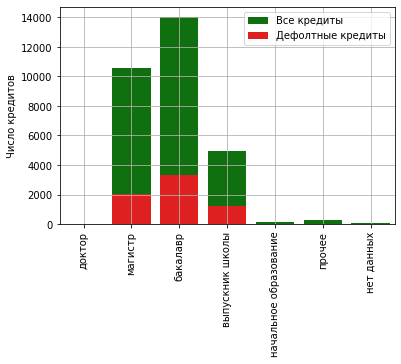

In [22]:
ax = sns.barplot(x=cont_table.index, y=cont_table.sum(axis=1), 
            label="Все кредиты", color="g")
ax = sns.barplot(x=cont_table.index, y=cont_table['default'], 
            label="Дефолтные кредиты", color="r")
ax.legend()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Число кредитов')
ax.grid()
plt.show()

Судя по графику, наиболее активно берут кредиты люди с образованием уровня магистр, бакалавр и выпускник школы. Оценить доли дефолтов по этому графику сложно.

## Расчет точечных оценок

Рассчитаем точечные оценки доли дефолтных кредитов для каждого уровня образования

In [23]:
row_totals = cont_table.sum(axis=1)
point_estimates = cont_table[['default']].div(row_totals, axis=0)
point_estimates.sort_values('default', ascending=False)

,default
выпускник школы,0.251576
бакалавр,0.237349
магистр,0.192348
нет данных,0.156863
прочее,0.064286
начальное образование,0.056911
доктор,0.000000


Согласно точечным оценкам, доля дефолтных кредитов для различно образованных групп заемщиков варьируется в диапазоне от 0 до 0.25.

## Проверка гипотезы

$H_0$ Уровень образования не влияет на вероятность возврата кредита

$H_1$ Уровень образования влияет на вероятность возврата кредита

Уровень значимости $\alpha = 0.05$

Критерий хи-квадрат независимостии Пирсона, односторонний

Проверим условие применимости выбранного критерия. 
1.   Объем выборки n > 40 - выполняется.
2.   Ожидаемое количество элементов в каждой ячейке таблицы $\frac{n_{i+}n_{+j}}{n}$ может быть меньше 5 не более, чем в 20% ячеек.

In [24]:
print(is_chi2_applicable(cont_table))

True


Условие 2 также выполняется, можно использовать выбранный критерий

In [25]:
chi2_stat, pvalue, _, expected_table = stats.chi2_contingency(cont_table)
print(f'Статистика критерия: {chi2_stat}, достигаемый уровень значимости: {pvalue}')

Статистика критерия: 163.21655786997073, достигаемый уровень значимости: 1.2332626245415605e-32


Вывод: достигаемый уровень значимости меньше $alpha$, результат статистически значим. Вероятность возврата кредита зависит от образования заемщика.

Сформируем таблицу отклонений наблюдаемого числа возвратов от ожидаемого числа

In [26]:
diff_table = cont_table - expected_table
diff_table

,normal,default
доктор,3.0968,-3.0968
магистр,305.4020,-305.4020
бакалавр,-226.5640,226.5640
выпускник школы,-149.3596,149.3596
начальное образование,20.2076,-20.2076
прочее,43.9360,-43.9360
нет данных,3.2812,-3.2812


При расчете ожидаемых значений в таблице сопряженности сумма по строке фиксируется. Иначе говоря, суммарное отклонение по строке равно нулю. Поскольку в нашей таблице всего 2 столбца, значения в смежных ячейках одной строки равны по модулю и противоположны по знаку. Попробуем визуализировать полученные отклонения. Достаточно использовать один столбец, возьмем данные по дефолтным кредитам. Положительные значения в нем соответствуют превышению наблюдаемого числа дефолтов над ожидаемым, отрицательные - превышению наблюдаемого числа возвратов над ожидаемым.

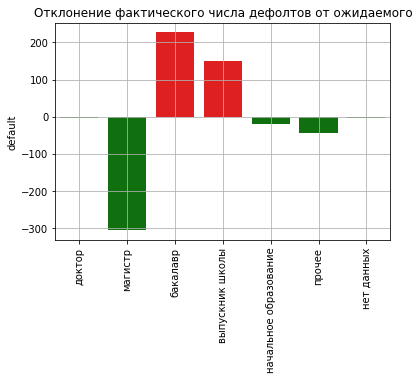

In [27]:
values = diff_table['default']
clrs = ['green' if (x < 0) else 'red' for x in values ]
ax = sns.barplot(x=diff_table.index, y=values, label="Все кредиты", palette=clrs)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid()
ax.title.set_text('Отклонение фактического числа дефолтов от ожидаемого')
plt.show()


Привести данные в таблице отклонений ожидаемого числа возвратов и дефолтов от наблюдаемого к одному масштабу можно, нормировав значения в этой таблице на общую численность заемщиков в каждой определяемой образованием группе.

In [28]:
norm_diff_table = diff_table.div(cont_table.sum(axis=1), axis=0)
norm_diff_table

,normal,default
доктор,0.221200,-0.221200
магистр,0.028852,-0.028852
бакалавр,-0.016149,0.016149
выпускник школы,-0.030376,0.030376
начальное образование,0.164289,-0.164289
прочее,0.156914,-0.156914
нет данных,0.064337,-0.064337


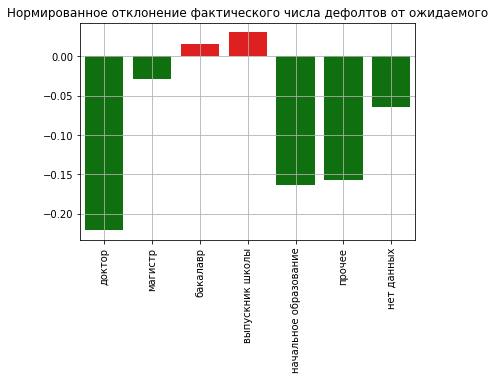

In [29]:
values = norm_diff_table['default']
clrs = ['green' if (x < 0) else 'red' for x in values ]
ax = sns.barplot(x=diff_table.index, y=values, label="Все кредиты", palette=clrs)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('')
ax.grid()
ax.title.set_text('Нормированное отклонение фактического числа дефолтов от ожидаемого')
plt.show()

Вывод:  

1.   наилучшим индикатором того, что человек **отдаст долг**, является наличие у него образования уровня **"доктор"**
2.   наилучшим индикатором того, что человек **не отдаст долг**, является наличие у него образования уровня **"выпускник школы"**



# 4.Анализ влияния семейного статуса на вероятность возврата кредита

## Подготовка данных

In [30]:
cont_table = pd.crosstab(data['MARRIAGE'], data['default'])
cont_table.index = ['отказываюсь отвечать', 'замужем/женат', 'холост', 'нет данных']
cont_table.columns = ['normal', 'default']
cont_table                     

,normal,default
отказываюсь отвечать,49,5
замужем/женат,10453,3206
холост,12623,3341
нет данных,239,84


## Визуальный анализ данных

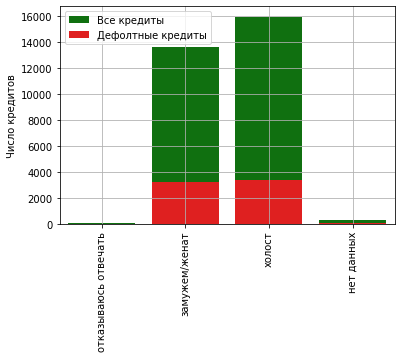

In [31]:
ax = sns.barplot(x=cont_table.index, y=cont_table.sum(axis=1), 
            label="Все кредиты", color="g")
ax = sns.barplot(x=cont_table.index, y=cont_table['default'], 
            label="Дефолтные кредиты", color="r")
ax.legend()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Число кредитов')
ax.grid()
plt.show()

## Расчет точечных оценок

Рассчитаем точечные оценки доли дефолтных кредитов для каждого семейного статуса

In [32]:
row_totals = cont_table.sum(axis=1)
point_estimates = cont_table[['default']].div(row_totals, axis=0)
point_estimates.sort_values('default', ascending=False)

,default
нет данных,0.260062
замужем/женат,0.234717
холост,0.209283
отказываюсь отвечать,0.092593


## Количественная оценка взаимосвязи семейного статуса и индикатора дефолта

В качестве меры взаимосвязи будем использовать коэффициент V Крамера. Так как в расчете используется статистика критерия хи-квадрат, необходимо проверить условия применимости данного критерия.

1.   Объем выборки n > 40 - выполняется.
2.   Ожидаемое количество элементов в каждой ячейке таблицы $\frac{n_{i+}n_{+j}}{n}$ может быть меньше 5 не более, чем в 20% ячеек.

In [33]:
print(is_chi2_applicable(cont_table))

True


Условие 2 также выполняется, можно использовать выбранный критерий

In [34]:
chi2_stat, pvalue, _, expected_table = stats.chi2_contingency(cont_table)
print(f'Статистика критерия: {chi2_stat}, достигаемый уровень значимости: {pvalue}')

Статистика критерия: 35.66239583433609, достигаемый уровень значимости: 8.825862457577375e-08


Рассчитаем коэффициент V Крамера

In [35]:
cramer_coeff = np.sqrt(chi2_stat / n)
cramer_coeff

0.034478203662766466

Вывод: полученное значение говорит о несущественной корреляции. Семейный статус не влияет на вероятность возврата кредита

---
# 5.Анализ влияния возраста заемщика на вероятность возврата кредита

## Подготовка данных

Разобъем данные по возрасту заемщиков на две подвыборки - возвращенные и дефолтные кредиты

In [36]:
age_normal = data[data['default'] == 0]['AGE']
age_default = data[data['default'] == 1]['AGE']

## Визуальный анализ данных

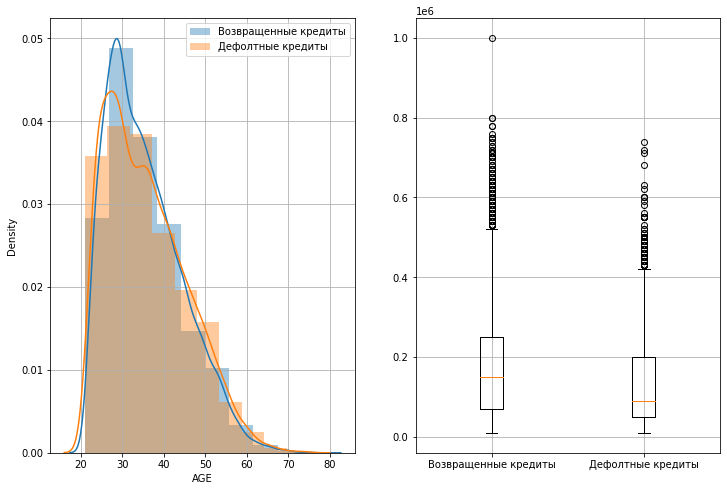

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
ax=axes[0]
age_data = [age_normal, age_default]
labels = ['Возвращенные кредиты', 'Дефолтные кредиты']

for d, l in zip(age_data, labels):
    sns.distplot(d, bins=10, ax=ax, kde=True, label=l)
ax.legend()
ax.grid()

ax = axes[1]
ax.boxplot(limit_data, vert=True, labels=labels)
ax.grid()
plt.show()

Выводы: распределения в подвыборках

*   не соответсвуют нормальному
*   мало отличаются друг от друга



## Расчет точечных оценок

In [38]:
print('Медиана возраста заемщика в подвыборке возвращенных кредитов: ', np.quantile(age_normal, 0.5))
print('Медиана возраста заемщика в подвыборке дефолтных кредитов: ', np.quantile(age_default, 0.5))

Медиана возраста заемщика в подвыборке возвращенных кредитов:  34.0
Медиана возраста заемщика в подвыборке дефолтных кредитов:  34.0


Вывод: точечные оценки медиан возраста заемщика в подвыборках возвращенных и дефолтных кредитов равны между собой

## Проверка распределение на нормальность

Выполним проверку визуально, с помощью qq-графика

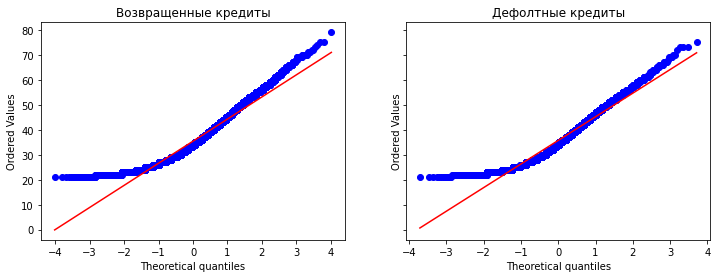

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True)
datasets = [age_normal, age_default]
titles = ['Возвращенные кредиты', 'Дефолтные кредиты']
for ax, dataset, title in zip(axes, datasets, titles):
    stats.probplot(dataset, dist="norm", plot=ax)
    ax.title.set_text(title)
plt.show()

Судя по графикам, распределение данных в обеих подвыборках отличается от нормального. Выполним проверку гипотезы о нормальности распределения.

$H_0$ Данные в подвыборках распределены нормально

$H_1$ Распределение данных в подвыборках не является нормальным

$\alpha = 0.05$

Критерий Шапиро-Уилка, односторонний

In [40]:
stat, pvalue = stats.shapiro(age_normal)
print(f'Подвыборка возвращенных кредитов: W-статистика = {stat}, p-value = {pvalue}')
stat, pvalue = stats.shapiro(age_default)
print(f'Подвыборка дефолтных кредитов: W-статистика = {stat}, p-value = {pvalue}')

Подвыборка возвращенных кредитов: W-статистика = 0.9496142864227295, p-value = 0.0
Подвыборка дефолтных кредитов: W-статистика = 0.9501640200614929, p-value = 1.0733946236728099e-42


Вывод: для обеих подвыборок p-value меньше уровня значимости, гипотезу о нормальности распределения можно отвергнуть.

## 5.a Построение доверительных интервалов


Построим доверительные интервалы для медианы возраста заемщика в подвыборках возвращенных и дефолтных кредитов на основе бутстрепа

Вид интервалов: двусторонние

Уровень значимости $\alpha = 0.05$

In [41]:
np.random.seed(42)
age_normal_medians = get_medians(age_normal)
age_default_medians = get_medians(age_default)
median_diffs = age_normal_medians - age_default_medians
print('95% доверительный интервал для медианы возраста заемщика:\n')
print('в подвыборке возвращенных кредитов', stat_intervals(age_normal_medians))
print('в подвыборке дефолтных кредитов', stat_intervals(age_default_medians))
print('\n95% доверительный интервал для разности медиан:', stat_intervals(median_diffs))


95% доверительный интервал для медианы возраста заемщика:

в подвыборке возвращенных кредитов [34. 34.]
в подвыборке дефолтных кредитов [34. 35.]

95% доверительный интервал для разности медиан: [-1.  0.]


Вывод: 95% доверительные интервалы для медиан подвыборок пересекаются. 95% доверительный интервал для разности медиан подвыборок содержит 0. Статистическая значимость не достигнута, нулевая гипотеза не отвергается

## 5.b Проверка гипотезы

Поскольку распределение не является нормальным, нужно использовать непараметрические критерии. Выборки независимы, можно применить критерий Манна-Уитни.

$H_0$ Распределения возраста заемщика в подвыборках возвращеных и дефолтных кредитов равны между собой

$H_1$ Распределения подвыборок отличаются сдвигом

$\alpha = 0.05$

Критерий Манна-Уитни, двусторонний


In [42]:
ustat, pvalue = stats.mannwhitneyu(age_normal, age_default, alternative='two-sided')
print(f'U-статистика: {ustat}, достигаемый уровень значимости: {pvalue}')

U-статистика: 76966879.5, достигаемый уровень значимости: 0.3725035434898616


Вывод: достигаемый уровень значимости больше $alpha$, нулевая гипотеза о равенстве распределений не отвергается.

Однако отсутствие статистической значимости не отменяет необходимости оценки практической значимости, так как в некоторых случаях статистически незначимое различие может быть практически значимо. Оценим практическую значимость по методике, изложенной в пункте 1

In [43]:
zscore = -stats.norm.ppf(pvalue / 2)
print(f'z-score: {zscore}')

z-score: 0.8917936545452849


In [44]:
r = zscore / np.sqrt(n)
print(f'Effect size: {r}')

Effect size: 0.005148773065133204


Следуя [рекомендованному эмпирическому правилу](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d), полученный размер эффекта нужно признать практически незначимым.

Вывод: возраст заемщика не влияет на вероятность возврата кредита